In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from statsmodels.stats.outliers_influence import variance_inflation_factor
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
import shap

In [ ]:
data = pd.read_excel("...")
data = data.dropna(axis=0, how='any')
data

,Default_flag_cus,DPD,HM,TGC/TSD,TGC/TTG,TTG/TSD,TGC/DT,GN/TGC,mean_HM_last_3m,max_DPD_last_3m,...,TTG_vol_2,DT_vol_1,DT_vol_3,DT_vol_4,TGC_vol_3,TSD_vol_3,TSD_vol_4,HM_vol_1,HM_vol_3,HM_vol_4
0,0.0,3.0,0.10,1.567434,0.880166,1.780838,1.025905,6.379853e+00,0.25,3.0,...,0.708837,274.881515,164.932405,0.599170,260.702889,-0.598847,1.001636,-0.6000,-0.600,1.000000
1,0.0,0.0,0.25,0.002963,0.003957,0.748601,-999998.000000,1.350171e+03,0.25,4.0,...,0.719644,-1.462812,-1.997999,1.318705,-2.747482,0.000000,0.997332,0.0000,0.000,1.000000
2,0.0,0.0,0.25,0.000002,0.000702,0.003303,-999998.000000,1.724138e+06,0.25,0.0,...,0.470229,0.000000,0.000000,1.014988,-0.000341,0.000000,1.000000,0.0000,0.000,1.000000
3,0.0,0.0,0.28,0.000005,0.000421,0.011245,-999998.000000,7.537688e+05,0.28,0.0,...,2.469861,0.000000,0.000000,0.071273,-0.658730,-0.398681,0.934731,0.0000,-0.400,0.933333
4,0.0,0.0,0.28,0.595331,2.262921,0.263081,-999998.000000,5.999060e+00,0.28,0.0,...,2.338110,0.000000,0.000000,0.073739,2.542265,-0.375000,0.875000,0.0000,-0.375,0.875000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168821,0.0,0.0,0.10,2.071526,315.126219,0.006574,256.742617,4.827359e-01,0.10,0.0,...,1.139156,0.000000,-888888.000000,1.283325,-888888.000000,-888888.000000,1.000000,0.0000,-888888.000,1.000000
168822,0.0,0.0,1.00,0.008671,0.961978,0.009013,1.031222,1.153304e+02,1.00,0.0,...,0.079998,0.000000,-888888.000000,1.052632,-888888.000000,-888888.000000,1.000000,0.0000,-888888.000,1.000000
168823,0.0,0.0,0.92,0.057613,5.525331,0.010427,1.816383,1.886648e+01,0.96,12.0,...,0.157764,-0.042424,-888888.000000,1.333333,-888888.000000,-888888.000000,0.989691,-0.0625,-888888.000,0.989691
168824,0.0,9.0,1.00,0.000000,0.000000,0.000044,0.000000,-9.999980e+05,1.00,7.0,...,1.470704,0.918498,-888888.000000,0.959350,-888888.000000,-888888.000000,1.001750,0.0000,-888888.000,1.000000


In [5]:
# Split the data into features (X) and target (y)
X = data.drop('Default_flag_cus', axis=1)
y = data['Default_flag_cus']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
threshold = 0.8

high_corr = []

while True:
    corr_matrix = X_train.corr().abs()

    mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    upper = corr_matrix.where(mask)

    high_corr_counts = (upper > threshold).sum()

    if high_corr_counts.max() == 0:
        break

    worst_feature = high_corr_counts.idxmax()
    high_corr.append(worst_feature)

    X_train = X_train.drop(columns=[worst_feature])

print("Dropping {} order:".format(len(high_corr)), high_corr)

X_test = X_test.drop(columns=high_corr)

Dropping 20 order: ['HM_vol_4', 'TSD_vol_4', 'mean_TTG/TSD_last_6m', 'mean_TGC/TSD_last_6m', 'mean_DT/TSD_last_6m', 'sum_DPD>10_last_6m', 'sum_DPD>0_last_6m', 'max_DPD_last_6m', 'mean_TTG/TSD_last_3m', 'mean_TGC/TSD_last_3m', 'mean_DT/TSD_last_3m', 'TTG/TSD', 'sum_DPD>0_last_3m', 'HM_vol_3', 'TGC/TTG', 'max_DPD_last_3m', 'mean_TGC/DT_last_6m', 'mean_GN/TGC_last_6m', 'TTG_vol_2', 'TSD_vol_3']


In [7]:
def compute_vif(df):
    vif = pd.DataFrame()
    vif['Variable'] = df.columns
    vif['VIF'] = [variance_inflation_factor(df.values, i) for i in range(vif.shape[0])]
    max_vif = max(vif['VIF'])
    high_vif = []
    while max_vif > 5:
        var = vif[vif['VIF'] == max_vif]['Variable']
        high_vif.append(var.iloc[0])
        df = df.drop(columns=var)
        vif = vif[vif['VIF'] != max_vif]
        vif = vif.reset_index(drop=True)
        vif['VIF'] = [variance_inflation_factor(df.values, i) for i in range(vif.shape[0])]
        max_vif = max(vif['VIF'])
    return high_vif

In [8]:
high_vif = compute_vif(X_train)

# Drop features with high VIF
print(f"Dropping {len(high_vif)} high VIF variables:", high_vif)

X_test = X_test.drop(columns=high_vif)

Dropping 0 high VIF variables: []


### 1. Vanilla model

In [9]:
# define XGBoost regressor
xgb = XGBClassifier(
    objective='binary:logistic',   # correct loss for 0/1 labels
    eval_metric='error',           # tracks accuracy = 1 – error
    tree_method='hist',
    random_state=42,
    n_jobs=-1
)
xgb.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'error'


In [10]:
y_pred = xgb.predict(X_test)

In [11]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.9679559320026062
Precision: 0.7130541871921182
Recall: 0.4054621848739496


### 2. Tuned model

In [ ]:
# search‐space for XGBoost hyperparameters
search_spaces = {
    'n_estimators': Integer(100, 5000),
    'max_depth': Integer(3, 25),
    'learning_rate': Real(1e-3, 0.3, prior='log-uniform'),
    'subsample': Real(0.0, 1.0, prior='uniform'),
    'colsample_bytree': Real(0.0, 1.0, prior='uniform'),
    'gamma': Real(0, 10, prior='uniform'),
    'reg_alpha': Real(1e-8, 20, prior='log-uniform'),
    'reg_lambda': Real(1e-8, 20, prior='log-uniform')
}

# BayesSearchCV to maximize recall
bayes_cv = BayesSearchCV(
    estimator=xgb, search_spaces=search_spaces, scoring='f1_score',
    n_iter=32, cv=5, n_jobs=-1, verbose=0
)

bayes_cv.fit(X_train, y_train)

,estimator,"XGBClassifier...ree=None, ...)"
,search_spaces,"{'colsample_bytree': Real(low=0.0,...m='normalize'), 'gamma': Real(low=0, h...m='normalize'), 'learning_rate': Real(low=0.00...m='normalize'), 'max_depth': Integer(low=3...m='normalize'), ...}"
,optimizer_kwargs,None
,n_iter,32
,scoring,'recall'
,fit_params,None
,n_jobs,-1
,n_points,1
,iid,'deprecated'
,refit,True
,cv,5


In [11]:
# Create a variable for the best model
best_xgb = bayes_cv.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  bayes_cv.best_params_)

Best hyperparameters: OrderedDict([('colsample_bytree', 1.0), ('gamma', 0.0), ('learning_rate', 0.3), ('max_depth', 3), ('n_estimators', 5000), ('reg_alpha', 1e-08), ('reg_lambda', 1e-08), ('subsample', 1.0)])


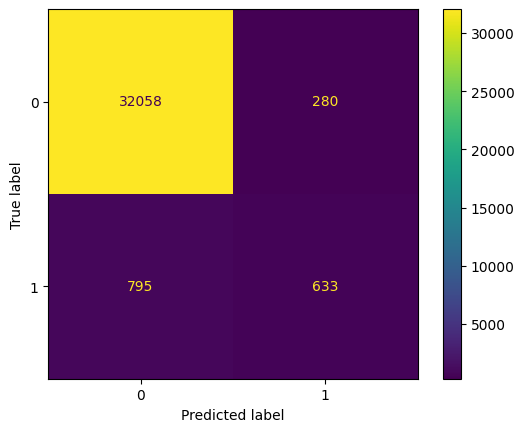

In [12]:
# Generate predictions with the best model
y_pred = best_xgb.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [12]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.9679559320026062
Precision: 0.7130541871921182
Recall: 0.4054621848739496


<Axes: >

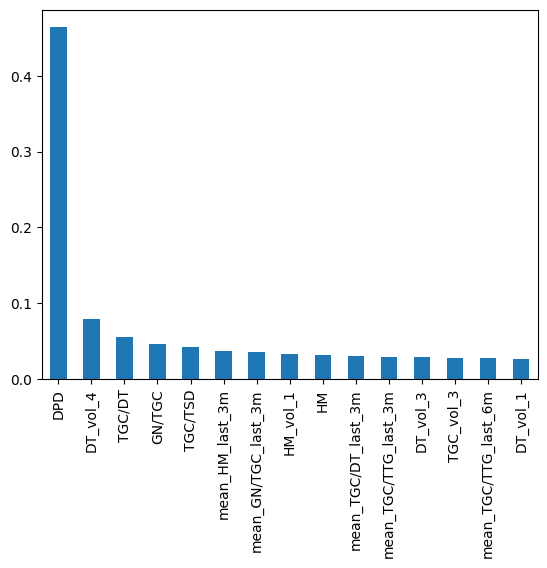

In [14]:
# Create a series contain feature importances from the model and feature names from the training data
feature_importances = pd.Series(xgb.feature_importances_, index=X_train.columns).sort_values(ascending=False)
# feature_importances = pd.Series(best_xgb.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar()

In [15]:
# Use SHAP to explain the model predictions
explainer = shap.TreeExplainer(xgb)
# explainer = shap.TreeExplainer(best_xgb)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

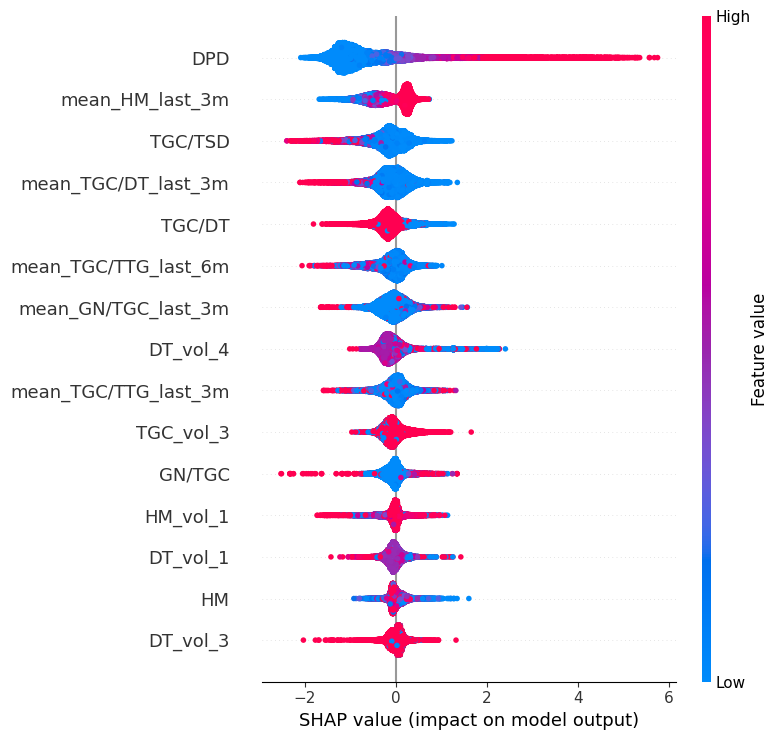

In [16]:
# Plot the SHAP values
shap.summary_plot(shap_values, X_test)